# Extraction of cell cycle phases by hierarchical clustering

We try to extract the phases of the cell cycle from our temporal network. We do so by:
1. Computing similarity/distance between every pair of adjacency snapshots
2. Performing hierarchical clustering on these distances

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy as sch

# ToDo: use 'with' statement instead?
import seaborn as sb
from ODEs.ode_solutions import OdeSolutions
sb.set_context("paper")

from clustering import clustering, drawing
from temporal_networks.temporal_network import TemporalNetwork

## Declare parameters to use throughout

In [2]:
distance_type = 'euclidean'
method = 'ward'
max_distance = 2
max_clusters = 6

project_base = '/Users/Teague/PycharmProjects/Marseille'
ode_filepath = project_base + '/example_data/bychen04_xpp.ode'
temporal_network_filepath = "example_data/tedges_combined_weighted_binary_method_percentage_minmax_p_0.5_clean2.tedges"

## Load our cell cycle temporal network

In [3]:
temporal_network = TemporalNetwork.from_file(temporal_network_filepath, "\s*\t\s*")

## Plot results

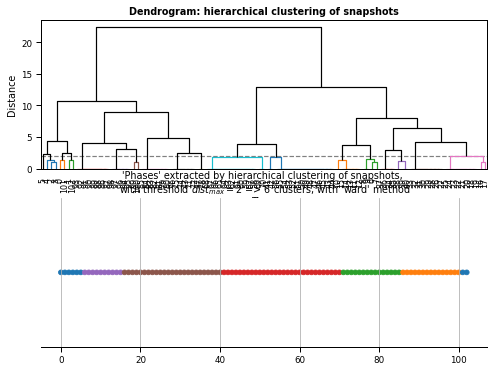

In [4]:
clusters = clustering.linkage(temporal_network, distance_type, method)
drawing.configure_colour_map()
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))
# fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 6))

# Plot clustering
dendrogram_title = 'Dendrogram: hierarchical clustering of snapshots'
drawing.plot_dendrogram_from_clusters(clusters, ax=ax1, max_distance=max_distance, title=dendrogram_title)

# Plot scatter graph of phases
flat_clusters = sch.fcluster(clusters, max_clusters, criterion='maxclust')
number_of_clusters = len(set(flat_clusters))
scatter_graph_title = \
    f"'Phases' extracted by hierarchical clustering of snapshots, \n " \
    f"with threshold $dist_{{max}} = {max_distance}$ => {number_of_clusters} clusters, " \
    f"with '{method}' method"
times = np.array(temporal_network.time_points(starting_at_zero=True))
drawing.plot_scatter_of_phases_from_flat_clusters(
    flat_clusters,
    times,
    number_of_colours=10,
    ax=ax2,
    title=scatter_graph_title)

plt.show()


### Run Chen

In [7]:
true_times = temporal_network.time_points(starting_at_zero=False)
start_time, end_time = int(true_times[0]), int(true_times[-1])
ode_solutions = OdeSolutions(ode_filepath, start_time, end_time)

In [ ]:
fig, ax = plt.subplots()

# find local minima
mass_series = ode_solutions.series('MASS')
mass_relative_minima_times = scipy.signal.argrelextrema(mass_series, np.less)
mass_relative_minima = mass_series[mass_relative_minima_times]

ax.plot(times, mass_series, 'o-')
ax.plot(times[mass_relative_minima_times], mass_relative_minima, 'ro')

print(f"min of mass: {mass_relative_minima} at indices {mass_relative_minima_times}")

In [ ]:
def plot_silhouette_sample(silhouette_sample, clusters, silhouette_avg, ax=None) :

    if ax==None:
        ax = plt.gca()

    n_clust = len(set(clusters))
    if n_clust > 10 :
        sb.set_palette("tab20")
    else :
        sb.set_palette("tab10")

    y_lower = 1
    for i in range(1, n_clust+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = silhouette_sample[clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

#         color = plt.cm.nipy_spectral(float(i) / n_clust)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=f"C{i-1}", edgecolor=f"C{i-1}", alpha=1)

        # Label the silhouette plots with their cluster numbers at the middle
#         ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        hpad = 1
        y_lower = y_upper + hpad  # 10 for the 0 samples

    ax.axvline(x=silhouette_avg, c='k', ls='--')

    # ax.set_ylim(1, len(clusters) + n_clust*hpad)

    # ax.set_title(f"The silhouette plot for the {n_clust} clusters.")
#     ax.set_xlabel("The silhouette coefficient values")
#     ax.set_ylabel("Cluster label")
#     ax.set_yticks([])
    sb.despine()


## Complete plot

In [ ]:
#-----------------------------------------------------------------

sb.set_palette('Dark2', n_colors=8)
var = ['CLN3', 'CLN2', 'CLB5', 'CLB2','MASS'] # +['ori']

t_G1 = 0
t_S = 36  # duration of G1, 36 min [Chen]
t_G2 = 78
t_M = 90
# cycle time, 101 min [Chen]

# phases = np.array([t_G1, t_S, t_G2, t_M, 100])
phases = np.array([0, 35, 70, 78, 100])
phases_mid = (phases[:-1] + phases[1:]) / 2
phases_labels = ['G1', 'S', 'G2', 'M']

plot_concentrations(var, times=times[:], ax=ax3, norm=True)
labelLines(plt.gca().get_lines(),zorder=2.5, xvals=[10, 90, 95, 55, 30])

for i in range(len(phases)-1) :
    ax3.axvspan(xmin=phases[i], xmax=phases[i+1], color='k', alpha=+ 0.1*i)

    ax3.text(phases_mid[i], 1.1, phases_labels[i], fontweight='bold',
             va='bottom', ha='center')

#------------------------------------ plot events

events_chen = [33, 84,36, 100]
event_chen_names = ['bud', 'spn', 'ori', 'mass']
for i, event in enumerate(events_chen) :
    ax2.axvline(x=event, c='k', label=event_chen_names[i], zorder=-2)
    ax2.text(event, 0.005, event_chen_names[i], fontsize='small', rotation=90, va='bottom', ha='right')

events = ['START', 'E3']
events_times = [5, 70]
for i, event in enumerate(events):
    ax2.axvline(x=events_times[i], c='k', ls='--', label=event[i], zorder=-2)
    ax2.text(events_times[i], 0.005, events[i], fontsize='small', rotation=90, va='bottom', ha='right')


# ax2.legend()

# plt.tight_layout()

ax2.get_shared_x_axes().join(ax2, ax3)
ax3.autoscale()
plt.subplots_adjust(hspace=0.9)

# plt.savefig(f"phases_from_clustering_maxclust_{maxclust}_mtd_{method}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{dir_}phases_from_clustering_maxclust_{maxclust}_mtd_{method}_{tag}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{dir_}phases_from_clustering_maxclust_{maxclust}_mtd_{method}_{tag}.pdf", dpi=250, bbox_inches="tight")



In [ ]:
methods = ['single', 'complete', 'average', 'ward']
i = 3
method = methods[i]

# compute dendrogram
linked = shc.linkage(dist_mat_condensed, method=method) #"ward")

maxclust_max = 15
maxclust_range = range(1, maxclust_max)
n_maxclust = len(maxclust_range)
clusters_arr = np.zeros((n_maxclust, T))
n_clust_arr = np.zeros(n_maxclust)

silhouette_avg_arr = np.zeros((n_maxclust))
silhouette_sample_arr = np.zeros((n_maxclust, T))

times = np.array(list(set(tnet.network.t))) # todo: deal with times in tnet, must be over 100

# compute array of clusters
for i, maxclust in enumerate(maxclust_range) :

    # compute clusters
    clusters = shc.fcluster(linked, maxclust, criterion='maxclust')

    clusters_arr[i] = clusters

    n_clusters = len(set(clusters))
    n_clust_arr[i] = n_clusters

    if n_clusters > 1 :
        silhouette_avg = metrics.silhouette_score(dist_mat, clusters, metric="precomputed")
        silhouette_avg_arr[i] = silhouette_avg

        silhouette_sample = metrics.silhouette_samples(dist_mat, clusters, metric="precomputed")
        silhouette_sample_arr[i] = silhouette_sample


In [ ]:
# plot array of clusters

gridspec_kw={"width_ratios": [9,2]}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw=gridspec_kw)

#-------------- main plot with time clusters
cs.plot_time_clusters(times, clusters_arr, ax=ax1)

ax1.set_ylabel("Max # clusters")
ax1.set_xlabel("Times (min)")

ax1.set_xticks(range(0, 100+5, 10))
ax1.set_ylim([-1, ax1.get_ylim()[1]])
ax1.grid(axis="x")
ax1.set_axisbelow(True)
sb.despine(ax=ax1)

#---------------- twin plot for labels on right
ax11 = ax1.twinx()
ax11.set_ylim(ax1.get_ylim())
ax11.set_yticks(maxclust_range)

labels_right = [int(n_clust) if (i==0 or np.diff(n_clust_arr)[i-1]!=0) else '' for i, n_clust in enumerate(n_clust_arr)]
ax11.set_yticklabels(labels_right)
sb.despine(ax=ax11, right=False)

# ax2.set_ylabel("Actual # clusters")

#----------- side plot
# divider = make_axes_locatable(ax)
# ax3 = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
# ax2 = divider.append_axes("right", size=1, pad=0.5)#, sharey=ax)

ax2.plot(silhouette_avg_arr, n_clust_arr, 'ko-')
ax2.set_xlim(xmax=1.1)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(maxclust_range)
ax2.set_yticklabels(labels_right)
ax2.set_ylabel("Actual # clusters")
ax2.set_xlabel("Average silhouette")

fig.suptitle(f"Hier. clust. method: '{method}' ({tag})")

plot_events(ax=ax1)
plot_phases(ax=ax1)

plt.subplots_adjust(wspace=0.4, top=0.8)

# plt.savefig(f"phase_clusters_all_method_{method}.png", dpi=250, bbox_inches="tight")
# plt.savefig(f"{dir_}phase_clusters_all_method_{method}_{tag}.png", dpi=250, bbox_inches="tight")
# plt.savefig(f"{dir_}phase_clusters_all_method_{method}_{tag}.pdf", dpi=250, bbox_inches="tight")

In [ ]:
n_clust_unique, idx_unique = np.unique(n_clust_arr, return_index=True) # indices of unique n_clust values
ncols = 4
n_unique = len(n_clust_unique) -1 # minus the 1-cluster
nrows = n_unique // ncols + n_unique % ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(10, 2 * nrows))

for i, j_uni in enumerate(idx_unique):

    ax = axs.flatten()[i-1]

    n_clusters = len(set(clusters_arr[j_uni]))

    ax.set_title(f"{n_clusters} clusters")
    plot_silhouette_sample(silhouette_sample_arr[j_uni], clusters_arr[j_uni], silhouette_avg_arr[j_uni], ax=ax)


if nrows > 1 :
    axes_left = axs[:,0]
else :
    axes_left = [axs[0]]

for ax in axes_left :
    ax.set_ylabel("Ordered time index")

for ax in axs.flatten()[-ncols:] :
    ax.set_xlabel("Silhouette score")

fig.suptitle(f"Sample silhouette, method: '{method}' ({tag})")

plt.subplots_adjust(top=0.8)

plt.savefig(f"{dir_}phase_clusters_silhouette_sample_method_{method}_{tag}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{dir_}phase_clusters_silhouette_sample_method_{method}_{tag}.pdf", dpi=250, bbox_inches="tight")

## K-means

In [ ]:
snapshots = tnet.df_to_array()
snapshots = np.swapaxes(snapshots, 0, 2) # put time as zeroth axis
snapshot_flat = snapshots.reshape(T, -1) # each matrix is flattened, represented as a vector

print(snapshots.shape)

In [ ]:
# methods = ['single', 'complete', 'average', 'ward']
# i = 3
# method = methods[i]
method = "kmeans"

# # compute dendrogram
# linked = shc.linkage(dist_mat_condensed, method=method) #"ward")

maxclust_max = 15
maxclust_range = range(1, maxclust_max)
n_maxclust = len(maxclust_range)
clusters_arr = np.zeros((n_maxclust, T))
n_clust_arr = np.zeros(n_maxclust)

silhouette_avg_arr = np.zeros((n_maxclust))
silhouette_sample_arr = np.zeros((n_maxclust, T))


# compute array of clusters
for i, nclust in enumerate(maxclust_range) :

    # compute clusters
#     clusters = shc.fcluster(linked, maxclust, criterion='maxclust')
    clusters = KMeans(n_clusters=nclust, random_state=None).fit_predict(snapshot_flat)

    clusters_arr[i] = clusters

    n_clusters = len(set(clusters))
    n_clust_arr[i] = n_clusters

    if n_clusters > 1 :
        silhouette_avg = metrics.silhouette_score(snapshot_flat, clusters, metric="euclidean")
        silhouette_avg_arr[i] = silhouette_avg

        silhouette_sample = metrics.silhouette_samples(snapshot_flat, clusters, metric="euclidean")
        silhouette_sample_arr[i] = silhouette_sample


In [ ]:
# plot array of clusters

gridspec_kw={"width_ratios": [9,2]}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw=gridspec_kw)

times = np.array(list(set(tnet.network.t))) # todo: deal with times in tnet, must be over 100
#-------------- main plot with time clusters
cs.plot_time_clusters(times, clusters_arr, ax=ax1)

ax1.set_ylabel("Max # clusters")
ax1.set_xlabel("Times (min)")

ax1.set_xticks(range(0, 100+5, 10))
ax1.set_ylim([-1, ax1.get_ylim()[1]])
ax1.grid(axis="x")
ax1.set_axisbelow(True)
sb.despine(ax=ax1)

#---------------- twin plot for labels on right
ax11 = ax1.twinx()
ax11.set_ylim(ax1.get_ylim())
ax11.set_yticks(maxclust_range)

labels_right = [int(n_clust) if (i==0 or np.diff(n_clust_arr)[i-1]!=0) else '' for i, n_clust in enumerate(n_clust_arr)]
ax11.set_yticklabels(labels_right)
sb.despine(ax=ax11, right=False)

# ax2.set_ylabel("Actual # clusters")

#----------- side plot
# divider = make_axes_locatable(ax)
# ax3 = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
# ax2 = divider.append_axes("right", size=1, pad=0.5)#, sharey=ax)

ax2.plot(silhouette_avg_arr, n_clust_arr, 'ko-')
ax2.set_xlim(xmax=1.1)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(maxclust_range)
ax2.set_yticklabels(labels_right)
ax2.set_ylabel("Actual # clusters")
ax2.set_xlabel("Average silhouette")

fig.suptitle(f"Hier. clust. method: '{method}' (with {tag})")

# cs.plot_events(ax=ax1)
# cs.plot_phases(ax=ax1)

plt.subplots_adjust(wspace=0.4, top=0.8)

plt.savefig(f"phase_clusters_kmeans_{tag}.png", dpi=250, bbox_inches="tight")

In [ ]:
times

# IGNORE BELOW HERE!

## Test on toy snapshots

In [ ]:
N = 3
T = 4
snapshots = np.random.randint(2, size=(T, N, N))

In [ ]:
snapshots

In [ ]:
_, distance_matrix_condensed = cluster_snapshots.compute_snapshot_distances(snapshots)
linked = shc.linkage(distance_matrix_condensed, method="ward")

fig, ax = plt.subplots()
dend = shc.dendrogram(linked)
plt.show()